<a href="https://colab.research.google.com/github/andygoosh/samsung/blob/master/workinprogress.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from pathlib import Path
from google.colab import files, drive
from collections import defaultdict

import re
import random as rn
import pandas as pd
import numpy as np
from numpy import array, argmax, random, take
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline

from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential, Model
from keras.layers import Input, Dropout, Dense, LSTM, GRU, Embedding, RepeatVector, TimeDistributed
from keras.layers import Bidirectional as Bi
from keras import optimizers
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping

RS = 77
rn.seed(RS)
# tf.random.set_seed(RS)
np.random.seed(RS)
np.random.RandomState(RS)

gpath = Path('/content/gdrive')
drive.mount(str(gpath))
data_file = gpath / 'My Drive/Samsung' / 'transcriptions'

Using TensorFlow backend.


KeyboardInterrupt: ignored

#### Let's look at the data in given file

In [0]:
with data_file.open() as f:  
    print(list(f.readline()))

#### Notice that:
1. russian sentence is separated from transcript with '\t'
2. the begining and the end of transcript part are marked by '%%'

### Let's read the data and split it into rus and trans

In [0]:
rus_trn = []
with data_file.open() as f:  
  for line in f: 
    rus, trn = line.split('\t')
    rus_trn.append([rus.strip(), trn.strip()])

print(f'Number of sentences in corpus: {len(rus_trn)}')

##### Let's look at some sentences


In [0]:
a,b,c = np.random.choice(len(rus_trn), 3)

print(rus_trn[a][0])
print(rus_trn[a][1])
print(rus_trn[b][0])
print(rus_trn[b][1])
print(rus_trn[c][0])
print(rus_trn[c][1])

#### Notice that words in russian sentence are separated by space while words in transcript are separated:
1. by '#' in general case
2. by '_' in case of preposition
3. by '%% %%' in case of punctuation signs (dash, coma, etc)


#### Let's see if we have dupliates in corpus

In [0]:
a = array(rus_trn)
seen_rus = Counter(a[:,0])
seen_trn = Counter(a[:,1])

print(f'Unique rus sentences: {len(seen_rus)} out of {len(rus_trn)}')
print(f'Unique trans sentences: {len(seen_trn)} out of {len(rus_trn)}')

#### We have a lot of duplicates! Only 3131 unique sentenses out of 50K in corpus. Please also note that some russian sentences are transcribed into different transcriptions (will look into that later on)

In [0]:
lens = [each[1] for each in seen_rus.items()]
unq = np.unique(lens)
qty = [lens.count(each) for each in unq]
pd.DataFrame(qty, index=unq).plot.bar(title = 'Rus sentence repeat times', legend=False);

#### Most duplicated sentences repeat 12 times, max up to 203 times

### Let's read that data while splitting the tokens. We'll count the tokens in each sentence. If the count in rus and trans is different, we'll record it as anomaly


In [0]:
rus_l, trn_l, anomaly = [], [], []
seen = defaultdict(list)
chars = Counter()

for j,i in enumerate(rus_trn):
  rus = i[0].split()
  trn = re.split('#|_|%% %%',i[1])

  if i[0] not in seen:
    if abs(len(rus) - len(trn)) != 0: 
      anomaly.append(j)
      # print(j, ' ', i[0])
      # print( i[1])
    
    else:
      rus_l.append(len(rus))
      trn_l.append(len(trn))

    chars += Counter(i[0])

  seen[i[0]].append(j)

print(f'Anomalies: {len(anomaly)}')
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2,figsize=(12,4))
pd.DataFrame({'Number of words in Rus sentence':rus_l}).hist(ax=ax1, bins = 30);
pd.DataFrame({'Number of words in Trns sentence':trn_l}).hist(ax=ax2, bins = 30);

#### So we have 49 anomalies out of 3131 samples

### Let's see if we need to clean the data. First let's take a look at rus corpus alphabet

In [0]:
s = sorted(chars.items())
pd.DataFrame(s, index=(e[0]+' ' for e in s)).plot.bar(figsize=(18,4), rot=0, title = 'Char frequencies', legend=False)
print(f'Number of times "-" used: {chars["-"]}')

#### Looks good! We neither have punctuations nor capital letters. The only case to check is '-' letter which is used 159 times

In [0]:
seen = set()
seen_dash = set()
dash_words = []
for rus,trn in rus_trn:
  if rus not in seen:
    if '-' in rus:
      ru_words = rus.split()
      for each in ru_words:
        if '-' in each:
          if each not in seen_dash:
            seen_dash.add(each)
            dash_words.append(each)
  else:
    seen.add(rus)
  
print(dash_words)

#### Okey, words with dash look fine, we'll consider dash as a normal letter

### So in order to implement autocoder for transcript we'd need to keep special symbools in transcript such as "\_" and "%% %%". So let's create a dictionary of sentences rus <-> trans. So let's recreate the dictionary so "\_" and "%% %%" are marked with '#' and remove begin and end markers. Plus to that let's get rid of duplicates.


In [0]:
# !pip3 install transliterate
# from transliterate import translit
# translit('длавды дылпадыал лыдап', 'ru', reversed=True)

In [0]:
seen_rus = set()
seen_trn = set()

res, trn_l, rus_l = [], [], []
for rus, trn in rus_trn:

  if rus not in seen_rus or trn not in seen_trn:
      seen_rus.add(rus)
      seen_trn.add(trn)

      # trn = trn.replace('%% %%', '%% %% #').replace('_', '_ #')[3:-3]
      # rus_l.append( len(rus))
      # trn_l.append( len(trn.split(' ')))
      # res.append([rus, trn.split(' ')])

      trn = trn.replace('%% %%', '%% %% #').replace('_', '_ #')[2:-2]
      rus_l.append( len(rus.split()))
      trn_l.append( len(trn.split('#')))
      # res.append([rus.split(), ['<sos>'] + trn.split('#'), ['<sos>'] + trn.split('#')])
      res.append([rus.split(), trn.split('#')])

rus_trn_new = array(res)
trn_length = max(trn_l)
rus_length = max(rus_l)
print(f'max len rus: {rus_length}, max len trn: {trn_length}')
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2,figsize=(12,4))
pd.DataFrame({'Number of words in Rus sentence':rus_l}).hist(ax=ax1, bins = 30);
pd.DataFrame({'Number of words in Trns sentence':trn_l}).hist(ax=ax2, bins = 30);

In [0]:
rus_trn_new[0]

### Text to Sequence Conversion

In [0]:
def tokenization(lines, split=' ', char_level=False):
  tokenizer = Tokenizer(filters='', lower=False, split=split, char_level=char_level)
  tokenizer.fit_on_texts(lines)
  return tokenizer

def encode_sequences(tokenizer, length, lines):
  seq = tokenizer.texts_to_sequences(lines)
  seq = pad_sequences(sequences=seq, maxlen=length, padding='post')
  return seq

In [0]:
rus_tokenizer = tokenization(rus_trn_new[:, 0], split='',  char_level=True)
rus_vocab_size = len(rus_tokenizer.word_index) + 1
trn_tokenizer = tokenization(rus_trn_new[:, 1], split=' ', char_level=False)
trn_vocab_size = len(trn_tokenizer.word_index) + 1
print(f'Rus Vocabulary Size: {rus_vocab_size}')
print(f'Trns Vocabulary Size: {trn_vocab_size}')
a = np.random.choice(rus_vocab_size)
print(trn_tokenizer.index_word[a])
print(rus_tokenizer.index_word[a])

### Model Building


In [0]:
rus_trn_new.shape

In [0]:
train, test = train_test_split(rus_trn_new, test_size=0.01, random_state = RS)

# prepare training data
trainX = encode_sequences(rus_tokenizer, rus_length, train[:, 0])
# trainX_ = encode_sequences(trn_tokenizer, trn_length, train[:, 2])
trainY = encode_sequences(trn_tokenizer, trn_length, train[:, 1])

# prepare validation data
testX = encode_sequences(rus_tokenizer, rus_length, test[:, 0])
# testX_ = encode_sequences(trn_tokenizer, trn_length, test[:, 2])
testY = encode_sequences(trn_tokenizer, trn_length, test[:, 1])

trainX.shape, testX.shape

In [0]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print(f'{t} ----> {lang.index_word[t]}')

a = np.random.choice(len(trainX))
convert(rus_tokenizer, trainX[a])
print ()
convert(trn_tokenizer, trainY[a])

#### FastText

In [0]:
from gensim.models.fasttext import FastText
rus_model = FastText(size=20)
trn_model = FastText(size=20)

rus_model.build_vocab(sentences=rus_trn_new[:, 0])
trn_model.build_vocab(sentences=rus_trn_new[:, 1])

total_rus = rus_model.corpus_total_words
total_trn = trn_model.corpus_total_words
print(total_rus, total_trn)

rus_model.train(sentences=rus_trn_new[:,0], total_examples = rus_model.corpus_count, epochs=rus_model.iter)
trn_model.train(sentences=rus_trn_new[:,1], total_examples = trn_model.corpus_count, epochs=trn_model.iter)

print(rus_model.wv['и'])
print(trn_model.wv[" i _ "])

rus_model.wv.similar_by_vector(trn_model.wv[" i _"])
# trn_model.wv.similar_by_vector(rus_model.wv['группа'])

In [0]:
trn_model.most_similar(' d' 'ix p u t a1 t ')
# rus_model.most_similar('депутат')

### Moving on

In [0]:
trainY[17]

In [0]:
BS = 128
EPOCHES = 500

def define_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
  input = x = Input(shape=(None,))
  x = Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True)(x)
  x, h, c = LSTM(units, return_state=True)(x)
  x = RepeatVector(out_timesteps)(x)
  x = LSTM(units, return_sequences=True)(x, initial_state = (h, c))
  output = TimeDistributed(Dense(out_vocab, activation='softmax'))(x)
  inference_model = model = Model(input, output)
  return model, inference_model

def define_model1(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
   # encoder
  encoder_inputs = Input(shape=(None,))
  encoder_embedding = Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True)
  encoder = encoder_embedding(encoder_inputs)
  _, state_h, state_c = LSTM(units, return_state=True)(encoder)
  encoder_states = [state_h, state_c]
  # decoder
  decoder_inputs = Input(shape=(None,))
  decoder_embedding = Embedding(out_vocab, units, input_length=out_timesteps, mask_zero=True)
  decoder = decoder_embedding(decoder_inputs)
  decoder_lstm = LSTM(units, return_sequences=True, return_state=True)
  decoder_outputs, _, _ = decoder_lstm(decoder, initial_state=encoder_states)
  decoder_dense = Dense(out_vocab, activation='softmax')
  decoder_outputs = decoder_dense(decoder_outputs)
  model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

  #inference model
  encoder_model = Model(encoder_inputs, encoder_states)
  decoder_state_input_h = Input(shape=(units,))
  decoder_state_input_c = Input(shape=(units,))
  decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
  decoder_inputs_single = Input(shape=(None,))
  decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)
  decoder_outputs, h, c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)
  decoder_states = [h, c]
  decoder_outputs = decoder_dense(decoder_outputs)
  inference_model = Model(
      [decoder_inputs_single] + decoder_states_inputs,
      [decoder_outputs] + decoder_states
  )
  return model, inference_model

model, model_inf = define_model(rus_vocab_size, trn_vocab_size, rus_length, trn_length, 128)
model.summary()

# optimizer = optimizers.RMSprop(lr=0.001)
optimizer=optimizers.Adam()
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy')

monitor = 'val_loss'
mode = 'min'
filename = 'model.h5'
checkpoint = ModelCheckpoint(filename, monitor=monitor, verbose=1, save_best_only=True, mode=mode)
early_stop = EarlyStopping( patience=5, monitor=monitor, mode=mode)

# train model
history = model.fit(trainX, trainY.reshape(*trainY.shape, 1),
# history = model.fit([trainX,trainY], trainY.reshape(*trainY.shape, 1),
                    validation_data=(testX, testY.reshape(*testY.shape, 1)),
                    # validation_data=([testX,trainY], testY.reshape(*testY.shape, 1)),
                    epochs=EPOCHES, batch_size=BS, callbacks=[], 
                    verbose=1)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [0]:
# model = load_model('model.h5')
preds = model_inf.predict(testX)
preds1 = np.argmax(preds,axis=2)
a = np.random.choice(testY.shape[0])
preds[a], testY[a]
convert(trn_tokenizer, preds1[a])
print()
convert(rus_tokenizer, testX[a])


In [0]:
def get_word(n, tokenizer):
  for word, index in tokenizer.word_index.items():
      if index == n:
          return word
  return None
  
a = np.random.choice(trn_vocab_size)
t = []
for e in testX[0]:
  s = get_word(e, rus_tokenizer)
  if s: t.append(s)
print( ' '.join(t) )

t = []
for e in testY[0]:
  s = get_word(e, trn_tokenizer)
  if s: t.append(s)
print( '#'.join(t) )

In [0]:
preds_text = []
prd = preds[:3]
for i in prd:
  temp = []
  for j in range(len(i)):
    t = get_word(i[j], trn_tokenizer)
    if j > 0:
      if (t == get_word(i[j-1], trn_tokenizer)) or (t == None):
        temp.append('')
      else:
        temp.append(t+'#')
    else:
      if(t == None):
            temp.append('')
      else:
              temp.append(t+'#') 

  preds_text.append(''.join(temp))

def unpack(tensor):
  t = []
  for e in tensor:
    s = get_word(e, rus_tokenizer)
    if s: t.append(s)
  return ' '.join(t)

preds_text
# print( list(zip((unpack(e) for e in testX[:3]), preds_text)))
# pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})
# pred_df.sample(15)

# German

In [0]:
!wget http://www.manythings.org/anki/deu-eng.zip
!unzip deu-eng.zip

In [3]:
import re
import string
from numpy import array, argmax, random, take
import pandas as pd
import numpy as np
from keras.models import Sequential, Model
from keras.layers import Input, Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
% matplotlib inline
pd.set_option('display.max_colwidth', 200)

# function to read raw text file
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    file.close()
    return text
  
# split text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

# download data from http://www.manythings.org/anki/deu-eng.zip
data = read_text("deu.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

# use first 50,000 English-German sentence pairs
deu_eng = deu_eng[:50000,:]

# Text Pre-processing
# Remove punctuation
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,2] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]
 
# convert to lowercase
for i in range(len(deu_eng)):
    deu_eng[i,1] = deu_eng[i,1].lower() # input (DE)
    deu_eng[i,0] = deu_eng[i,0].lower() # target output (EN)

    deu_eng[i,2] = '<sos> ' + deu_eng[i,0] # target input (EN)
    deu_eng[i,0] = deu_eng[i,0] + ' <eos>'# target output (EN)


# Convert text to sequence 
# empty lists
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
    eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
    deu_l.append(len(i.split()))

# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
    tokenizer.fit_on_texts(lines)
    return tokenizer
  
# prepare english tokenizer
deu_eng[0, 0] = deu_eng[0, 0] + ' <sos>'
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

# prepare Deutch tokenizer
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1
deu_length = 8
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

# encode and pad sequences
def encode_sequences(tokenizer, length, lines, sos=False, eos=False):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq
  
# model building
# split data 
from sklearn.model_selection import train_test_split
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainX_ = encode_sequences(eng_tokenizer, eng_length, train[:, 2])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testX_ = encode_sequences(eng_tokenizer, eng_length, test[:, 2])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

English Vocabulary Size: 6347
Deutch Vocabulary Size: 10501


In [4]:
deu_eng[:, 2]

array(['<sos> hi', '<sos> hi', '<sos> run', ...,
       '<sos> he has no specific aim', '<sos> he has only four pesos',
       '<sos> he has stopped smoking'], dtype='<U537')

In [5]:
trainX[0], trainX_[0], trainY[0]

(array([ 53,   3, 325, 487,   0,   0,   0,   0], dtype=int32),
 array([4301,   68,    5,   22,  437,    0,    0,    0], dtype=int32),
 array([ 68,   5,  22, 437,   1,   0,   0,   0], dtype=int32))




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 8, 512)       5376512     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 8, 512)       3249664     input_2[0][0]                

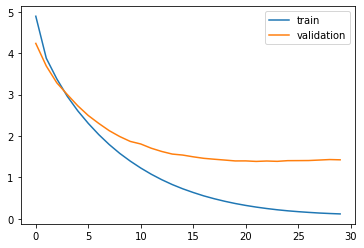

NameError: ignored

In [6]:
# build NMT model
def define_model1(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
  input = x = Input(shape=(None,))
  x = Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True)(x)
  x, h, c = LSTM(units, return_state=True)(x)
  x = RepeatVector(out_timesteps)(x)
  x = LSTM(units, return_sequences=True)(x, initial_state = (h, c))
  output = TimeDistributed(Dense(out_vocab, activation='softmax'))(x)
  inference_model = model = Model(input, output)
  return model, None, None

def define_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
   # encoder
  encoder_inputs = Input(shape=(None,))
  encoder_embedding = Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True)
  encoder = encoder_embedding(encoder_inputs)
  _, state_h, state_c = LSTM(units, return_state=True)(encoder)
  encoder_states = [state_h, state_c]
  # decoder
  decoder_inputs = Input(shape=(None,))
  decoder_embedding = Embedding(out_vocab, units, input_length=out_timesteps, mask_zero=True)
  decoder = decoder_embedding(decoder_inputs)
  decoder_lstm = LSTM(units, return_sequences=True, return_state=True)
  decoder_outputs, _, _ = decoder_lstm(decoder, initial_state=encoder_states)
  decoder_dense = Dense(out_vocab, activation='softmax')
  decoder_outputs = decoder_dense(decoder_outputs)
  model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

  #inference model
  encoder_model = Model(encoder_inputs, encoder_states)

  decoder_state_input_h = Input(shape=(units,))
  decoder_state_input_c = Input(shape=(units,))
  decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
  decoder_inputs_single = Input(shape=(None,))
  decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)
  decoder_outputs, h, c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)
  decoder_states = [h, c]
  decoder_outputs = decoder_dense(decoder_outputs)
  decoder_model = Model(
      [decoder_inputs_single] + decoder_states_inputs,
      [decoder_outputs] + decoder_states)
  
  # encoder_model = Model(encoder_inputs, encoder_states)

  # decoder_state_input_h = Input(shape=(units,))
  # decoder_state_input_c = Input(shape=(units,))
  # decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
  # decoder_outputs, state_h, state_c = decoder_lstm(
  #     decoder, initial_state=decoder_states_inputs)
  # decoder_states = [state_h, state_c]
  # decoder_outputs = decoder_dense(decoder_outputs)
  # decoder_model = Model(
  #     [decoder_inputs] + decoder_states_inputs,
  #     [decoder_outputs] + decoder_states)
  
  return model, encoder_model, decoder_model


model, encoder_model, decoder_model = define_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)
model.summary()
  
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

# train model
filename = 'model.h1.24_jan_19'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# history = model.fit(trainX, trainY.reshape(*trainY.shape, 1), 
#           validation_data=(testX, testY.reshape(*testY.shape, 1)),
#           epochs=30, batch_size=512, 
#           callbacks=[checkpoint], verbose=1)

history = model.fit([trainX, trainX_], trainY.reshape(*trainY.shape, 1), 
          epochs=30, batch_size=512, 
          validation_data=([testX,testX_], testY.reshape(*testY.shape, 1)),
          callbacks=[checkpoint], verbose=1)

# plot validation loss vs training loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

# load saved model
model = load_model('model.h1.24_jan_19')

# make predictions
# preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))
# preds = model.predict_classes(testX)

preds_ohe = model_inf.predict(testX)
preds = np.argmax(preds_ohe,axis=2)

def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None
  
# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))
    
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

# display results
pred_df.sample(15)

In [8]:
trainX[10], trainX_[10], trainY[10]

(array([22, 75,  4, 76,  0,  0,  0,  0], dtype=int32),
 array([4301,   26,   67,   37,   11,    0,    0,    0], dtype=int32),
 array([26, 67, 37, 11,  1,  0,  0,  0], dtype=int32))

In [92]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

preds_ohe = model_inf.predict(testX)
preds = np.argmax(preds_ohe,axis=2)

# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))
    
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

# display results
pred_df.sample(15)

ValueError: ignored

In [86]:
def translate_sentence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']
    eos = word2idx_outputs['<eos>']
    output_sentence = []

    for _ in range(max_out_len):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])

        if eos == idx:
            break

        word = ''

        if idx > 0:
            word = trn_tokenizer.index_word[idx]
            output_sentence.append(word)

        target_seq[0, 0] = idx
        states_value = [h, c]

    return ' '.join(output_sentence)

def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, eng_vocab_size))
    # Populate the first character of target sequence with the start character.
    # target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [input_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence

i = np.random.choice(len(trainX))
input_seq = trainX[i]
# translation = decode_sequence(input_seq)

# Encode the input as state vectors.
states_value = encoder_model.predict(input_seq)

# Generate empty target sequence of length 1.
target_seq = np.zeros(deu_length)
# Populate the first character of target sequence with the start character.
target_seq[0] = 1.

# Sampling loop for a batch of sequences
# (to simplify, here we assume a batch of size 1).
stop_condition = False
decoded_sentence = ''
while not stop_condition:
    output_tokens, h, c = decoder_model.predict(
        [input_seq] + states_value)

    # Sample a token
    sampled_token_index = np.argmax(output_tokens, axis=2)
    sampled_char = reverse_target_char_index[sampled_token_index]
    decoded_sentence += sampled_char

    # Exit condition: either hit max length
    # or find stop character.
    if (sampled_char == '\n' or
        len(decoded_sentence) > max_decoder_seq_length):
        stop_condition = True

    # Update the target sequence (of length 1).
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    target_seq[0, 0, sampled_token_index] = 1.

    # Update states
    states_value = [h, c]


print('-')
print('Input:', input_sentences[i])
print('Response:', translation)

NameError: ignored